# 네이버 영화 리뷰 크롤링

### selenium  사용하여 데이터 수집

In [1]:
# 크롤링 및 전처리를 위한 모듈 불러오기
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt

import re
import pickle

import time

from bs4 import BeautifulSoup 
from bs4 import BeautifulSoup as bs

import urllib
from urllib.parse import urljoin
import urllib.request as req
from urllib.request import Request
from urllib.request import urlopen

import requests

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains

In [2]:
from collections import Counter
from konlpy.tag import Mecab
from konlpy.tag import Okt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
!pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=676dd719337cf9141a06af6418c335d74117c874accc9d2439597aa41df8588d
  Stored in directory: c:\users\lee\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor


In [2]:
# 날짜 월,별 지정
import datetime
a = datetime.datetime.today()
today = a.strftime('%m%d')
today

'0501'

In [15]:
# 리스트 초기화
review_list = []
rating_list = []

# selenium 네이버 영화 리뷰, 평점 가져오기
driver = webdriver.Chrome('C:/Users/lee/Desktop/Code/06.python/chromedriver.exe')

# url 접속
url = 'https://movie.naver.com/movie/point/af/list.nhn?'

try:
    driver.get(url)
    time.sleep(1)
except:
    print('접속에러')
time.sleep(1)

# 10 페이지
for pg_num in range(1,11):
    # 리뷰 10개
    for i in range(1,11):
        a = driver.find_element_by_xpath(f'//*[@id="old_content"]/table/tbody/tr[{i}]/td[2]')
        a_text = a.text.replace('신고','').split('\n')
        
        rating_list.append(int(a_text[2]))
        review_list.append(a_text[3])
        # print(f'별점 : {a_1[2]}, 리뷰:{a_1[3]}')
    
    if pg_num == 1 : 
        driver.find_element_by_xpath('//*[@id="old_content"]/div[2]/div/a[11]').click()
    else :
        driver.find_element_by_xpath('//*[@id="old_content"]/div[2]/div/a[12]').click()

driver.quit()

In [16]:
data_dict = {'rating':rating_list, 'review':review_list}

In [17]:
review_df = pd.DataFrame(data_dict)

In [18]:
review_df['rating'].value_counts().sort_index()

1     14
2      5
3      1
4      3
6      6
7      3
8     13
9      6
10    49
Name: rating, dtype: int64

In [19]:
# 긍정 리뷰 1 부정 리뷰 0 으로 분류
review_df['label'] = np.select([review_df.rating > 6], [1], default=0)
# review_df

In [20]:
review_df['label'].value_counts().sort_index()

0    29
1    71
Name: label, dtype: int64

In [21]:
# 리뷰 중복 제거
review_df.drop_duplicates(subset=['review'], inplace=True)

In [22]:
# null값 유무 확인
print(review_df.isnull().values.any())

False


In [23]:
review_df

,rating,review,label
0,7,"‘결국, 사랑은 시간을 선물하는 것 - 이동진’",1
1,10,"이런 명작을오늘 보고 되었다,너무나 감동 아니 감동 그 자체이다",1
2,10,,1
3,10,임창정 나왔으면 10점 줘야지,1
4,1,감독 대체 뭔 생각으로 만든거지 결말이 아x발꿈 < 이것만큼이나 엿같음,0
...,...,...,...
95,10,완전 강추.. 스스로에게 묵직함을 주는듯..,1
96,10,오랜만에 따듯하고 감성적이면서 잔잔한 감동도 느낄 수 있는 영화라 너무 좋았습니다 ...,1
97,9,위선과 낭만의 시대가 나은 걸작 '시민케인'을 맹크의 시점으로 풀어낼 수 밖에 없는...,1
98,10,반전의 반전이...ㅜㅜ전개가 긴장감 있어서 좋았습니다,1


# 데이터 불러오기 후 저장 최신화

In [24]:
# 데이터 원본 저장 a = 추가하기
review_df.to_csv('naverMovieReview.csv',mode='a',index=False,header=False ,encoding='euc-kr')

# 기존데이터와 합쳐서 중복,null 제거
df_1=pd.read_csv('naverMovieReview.csv',header=None,encoding='euc-kr')
df_1 = df_1.rename(columns={0:'rating',1:'review',2:'label'})
df_1.drop_duplicates(subset=['review'], inplace=True)
df_1.dropna(subset=['review'], inplace=True)

# 최신화 데이터로 저장 w 덮어쓰기
df_1.to_csv('naverMovieReview.csv',mode='w',index=False,header=False, encoding='euc-kr')

# 최신데이터 불러오기

In [25]:
df = pd.read_csv('naverMovieReview.csv',header=None,encoding='euc-kr')
df = df.rename(columns={0:'rating',1:'review',2:'label'})

In [26]:
df

,rating,review,label
0,2,내가 문제있는걸까 내가 명작을 못 알아보는 사람인가 싶었던 영화....도대체 어떤 ...,0
1,10,김영광 윤선빈 연기 액션 모두 좋았습니다.코로나 때문에 관객이 적어서 안타깝습니다....,1
2,8,스티브연 멋지고 매력 있네요.,1
3,10,아이들이 정말 재미있게 봤어요. 자극적인 영화가 많은데 잔잔히 흐르는 재즈 선율과 ...,1
4,6,프로 불편러들 존나 많네 .... 페미년들 ㅉㅉ,0
...,...,...,...
386,10,완전 강추.. 스스로에게 묵직함을 주는듯..,1
387,10,오랜만에 따듯하고 감성적이면서 잔잔한 감동도 느낄 수 있는 영화라 너무 좋았습니다 ...,1
388,9,위선과 낭만의 시대가 나은 걸작 '시민케인'을 맹크의 시점으로 풀어낼 수 밖에 없는...,1
389,10,반전의 반전이...ㅜㅜ전개가 긴장감 있어서 좋았습니다,1


In [27]:
# 훈련 데이터, 테스트 데이터 분리
train_data, test_data = train_test_split(df, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 293
테스트용 리뷰의 개수 : 98


# 데이터 정제

In [28]:
# 훈련 데이터 정제하기
# 한글과 공백을 제외하고 모두 제거
train_data['review'] = train_data['review'].replace('[^ㄱ-ㅎ|ㅏ-ㅣ|가-힣]','',regex=True)
print(train_data.isnull().sum())

rating    0
review    0
label     0
dtype: int64


<ipython-input-28-685c5623c923>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['review'] = train_data['review'].replace('[^ㄱ-ㅎ|ㅏ-ㅣ|가-힣]','',regex=True)


In [29]:
test_data['review'] = test_data['review'].replace('[^ㄱ-ㅎ|ㅏ-ㅣ|가-힣]','',regex=True)
print(test_data.isnull().sum())

rating    0
review    0
label     0
dtype: int64


<ipython-input-29-a97168cca845>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['review'] = test_data['review'].replace('[^ㄱ-ㅎ|ㅏ-ㅣ|가-힣]','',regex=True)


# 토큰화

In [30]:
okt = Okt()
print(okt.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이라고', '차라리', '내', '가', '만드는', '게', '나을', '뻔']


In [31]:
# 불용어 지정
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를',
             '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '나', '요',]

In [32]:
# 훈련데이터 토큰화 
train_data['tokenized'] = train_data['review'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x : [item for item in x if item not in stopwords])

<ipython-input-32-40ad51e39d0f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tokenized'] = train_data['review'].apply(okt.morphs)
<ipython-input-32-40ad51e39d0f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tokenized'] = train_data['tokenized'].apply(lambda x : [item for item in x if item not in stopwords])


In [33]:
# 테스트 데이터 토큰화
test_data['tokenized'] = test_data['review'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x : [item for item in x if item not in stopwords])

<ipython-input-33-5b3b6f1a8506>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['tokenized'] = test_data['review'].apply(okt.morphs)
<ipython-input-33-5b3b6f1a8506>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['tokenized'] = test_data['tokenized'].apply(lambda x : [item for item in x if item not in stopwords])


# 단어와 길이 분포 확인하기

In [34]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [35]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('영화', 65), ('그', 13), ('에서', 13), ('너무', 12), ('배우', 11), ('연기', 11), ('으로', 11), ('스토리', 10), ('진짜', 10), ('연출', 9), ('적', 9), ('로', 8), ('느낌', 8), ('평점', 7), ('뻔한', 7), ('하고', 7), ('감독', 7), ('아', 7), ('이런', 6), ('화', 6)]


In [36]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('영화', 84), ('적', 32), ('에서', 30), ('로', 29), ('감동', 24), ('너무', 23), ('생각', 19), ('그', 18), ('으로', 17), ('스토리', 17), ('것', 17), ('하고', 16), ('배우', 16), ('입니다', 15), ('연출', 14), ('연기', 14), ('정말', 13), ('진짜', 13), ('레', 13), ('까지', 12)]


긍정 리뷰의 평균 길이 : 16.119617224880383
부정 리뷰의 평균 길이 : 20.61904761904762


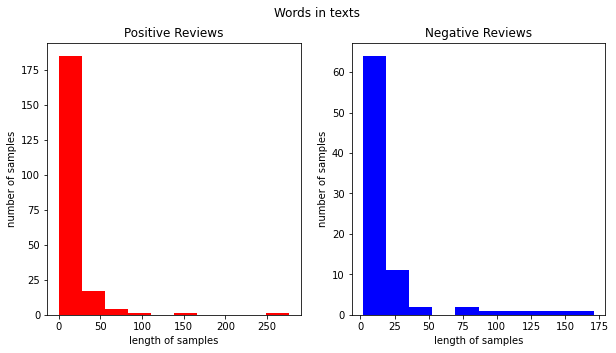

In [39]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [40]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

#  정수 인코딩
이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 우선, 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.

In [41]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 tokenizer.word_index를 출력하여 확인 가능합니다. 등장 횟수가 1회인 단어들은 자연어 처리에서 배제하고자 합니다. 이 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [42]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 2689
등장 빈도가 1번 이하인 희귀 단어의 수: 1988
단어 집합에서 희귀 단어의 비율: 73.93082930457419
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 38.97275044108998
